之前几章介绍了基于值函数的方法 DQN、基于策略的方法 REINFORCE 以及两者结合的方法 Actor-Critic。**它们都是无模型（model-free）的方法**，即没有建立一个环境模型来帮助智能体决策。

而在深度强化学习领域下，基于模型（model-based）的方法通常用神经网络学习一个环境模型，然后利用该环境模型来帮助智能体训练和决策。

利用环境模型帮助智能体训练和决策的方法有很多种，例如可以用与之前的 Dyna 类似的思想生成一些数据来加入策略训练中。

本章要介绍的**模型预测控制（model predictive control，MPC）算法** 并不构建一个显式的策略，只根据环境模型来选择当前步要采取的动作。

## 打靶法

首先，让我们用一个形象的比喻来帮助理解模型预测控制方法。

假设我们在下围棋，现在根据棋盘的布局，我们要选择现在落子的位置。一个优秀的棋手会根据目前局势来推演落子几步可能发生的局势，然后选择局势最好的一种情况来决定当前落子位置。

**模型预测控制方法就是这样一种迭代的、基于模型的控制方法。**

**值得注意的是，MPC 方法中不存在一个显式的策略。** 

具体而言，MPC 方法在每次采取动作时，
- 首先会生成一些候选动作序列，然后根据当前状态来**确定每一条候选序列能得到多好的结果**，
- 最终选择结果最好的那条动作序列的第一个动作来执行。

因此，在使用 MPC 方法时，**主要在两个过程中迭代**；
- 一是根据历史数据学习环境模型$P^\^{(s,a)}$，
- 二是在和真实环境交互过程中用环境模型来选择动作。

首先，我们定义模型预测方法的目标。在第k步时，我们要想做的就是最大化智能体的累积奖励，

具体来说就是：

In [1]:
from IPython.display import Image

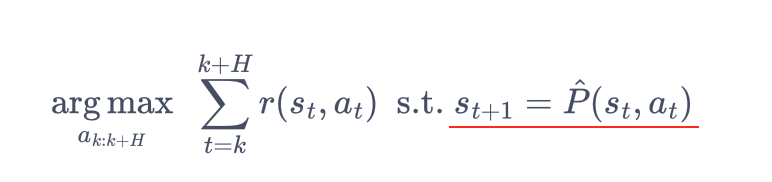

In [2]:
Image(filename='./daba.png')

- H为推演的长度，
- $argmax_{a_{k:k+H}}$表示从所有动作序列中选取累积奖励最大的序列。

我们每次取最优序列中的第一个动作$a_k$来与环境交互。

**MPC 方法中的一个关键是如何生成一些候选动作序列**，候选动作生成的好坏将直接影响到 MPC 方法得到的动作。

生成候选动作序列的过程我们称为**打靶（shooting）**。

### 随机打靶法

随机打靶法（random shooting method）的做法便是**随机生成N条动作序列**，即在生成每条动作序列的每一个动作时，都是从动作空间中随机采样一个动作，最终组合成N条长度为H的动作序列。

**对于一些简单的环境，这个方法不但十分简单，而且效果还不错。**

**那么，能不能在随机的基础上，根据已有的结果做得更好一些呢？**

接下来，我们来介绍另外一种打靶法：**交叉熵方法**。


### 交叉熵方法

交叉熵方法（cross entropy method，CEM）**是一种进化策略方法**，

**它的核心思想是**维护一个带参数的分布，根据每次采样的结果来更新分布中的参数，使得分布中能获得较高累积奖励的动作序列的概率比较高。

相比于随机打靶法，**交叉熵方法能够利用之前采样到的比较好的结果，在一定程度上减少采样到一些较差动作的概率**，从而使得算法更加高效。对于一个与连续动作交互的环境来说，每次交互时交叉熵方法的做法如下：


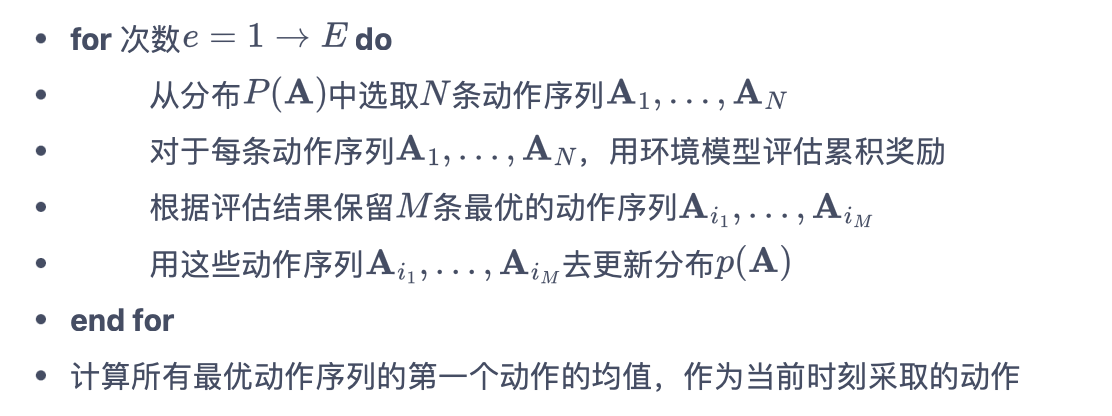

In [3]:
Image(filename='./cem.png')

### 我们可以使用如下的代码来实现交叉熵方法，其中将采用截断正态分布。

In [6]:
import numpy as np
from scipy.stats import truncnorm
import gym
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import matplotlib.pyplot as plt

In [8]:
# 参数
a, b = 0, 2  # 截断区间 [0, 2]
mu, sigma = 1, 0.5  # 均值和标准差

# 创建截断正态分布对象
dist = truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)

# 生成随机数
samples = dist.rvs(1000)

print(samples[:10])  # 打印前 10 个样本

[1.3957843  1.31467546 0.09630402 0.19044478 1.5827558  1.4631557
 1.55725208 1.14436865 1.53645217 1.12878419]


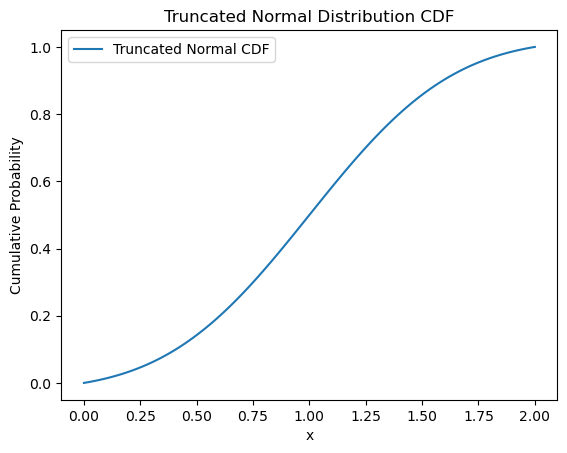

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# 参数
a, b = 0, 2  # 截断区间 [0, 2]
mu, sigma = 1, 0.5  # 均值和标准差

# 创建截断正态分布对象
dist = truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)

# 生成 x 值
x = np.linspace(a, b, 100)

# 计算 CDF
cdf = dist.cdf(x)

# 绘制 CDF 图
plt.plot(x, cdf, label='Truncated Normal CDF')
plt.xlabel('x')
plt.ylabel('Cumulative Probability')
plt.title('Truncated Normal Distribution CDF')
plt.legend()
plt.show()

In [ ]:
class CEM:
    def __init__(self, n_sequence, elite_ratio, fake_env, upper_bound,
                 lower_bound):
        self.n_sequence = n_sequence
        self.elite_ratio = elite_ratio
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.fake_env = fake_env

    def optimize(self, state, init_mean, init_var):
        mean, var = init_mean, init_var
        # 截断正太分布
        # 截断正态分布是一种在指定区间内截断的正态分布，即只保留分布中的一部分，超出指定区间的部分被截断。
        X = truncnorm(-2, 2, loc=np.zeros_like(mean), scale=np.ones_like(var))
        
        state = np.tile(state, (self.n_sequence, 1))
        for _ in range(5):
            lb_dist, ub_dist = mean - self.lower_bound, self.upper_bound - mean
            constrained_var = np.minimum(np.minimum(np.square(lb_dist / 2),
                                                    np.square(ub_dist / 2)),var)
            # 生成动作序列
            action_sequences = [X.rvs() for _ in range(self.n_sequence)] * np.sqrt(constrained_var) + mean
            # 计算每条动作序列的累积奖励
            returns = self.fake_env.propagate(state, action_sequences)[:, 0]
            # 选取累积奖励最高的若干条动作序列
            elites = action_sequences[np.argsort(
                returns)][-int(self.elite_ratio * self.n_sequence):]
            new_mean = np.mean(elites, axis=0)
            new_var = np.var(elites, axis=0)
            # 更新动作序列分布
            mean = 0.1 * mean + 0.9 * new_mean
            var = 0.1 * var + 0.9 * new_var

        return mean